In [ ]:
import os
import numpy as np
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM,Bidirectional, GRU, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dharshanan","key":"84f0a0f6b4b628769ed92a0e4ee89896"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:07<00:00, 202MB/s]
100% 1.04G/1.04G [00:08<00:00, 138MB/s]


In [ ]:
!unzip "/content/flickr8k.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [ ]:


BASE_DIR = '/content/'
WORKING_DIR = '/content/'



In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:

import pickle
#  pickle is used to store data types in py like tuples
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))



In [ ]:
import pickle

# load features from pickle
with open(os.path.join(WORKING_DIR, '/content/drive/MyDrive/Colab Notebooks/Models/features.pkl'), 'rb') as f:
    features = pickle.load(f)



In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()


In [ ]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2: #we need atleast more than 2 words/tokens to create sentence
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:


#len  return the no.of obj present
len(mapping)



8091

In [ ]:


def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
         caption = captions[i]
        # preprocessing steps
        # convert to lowercase
        caption = caption.lower()
        # delete digits, special chars, etc.,
        caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
        caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
        captions[i] = caption



In [ ]:


all_captions = [] #fetch all capt from dataset
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)



In [ ]:


len(all_captions)

40455

In [ ]:


#tokenization= break dwon of the text into words w.r.t grammar/parts of speech
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 #l

In [ ]:
#for single processing
max_length = max(len(caption.split()) for caption in all_captions)
max_length


37

In [ ]:


#HERE WE SPLIT THE DATA INTO  TRAIN 90-TEST 10 SPLIT FOR BETTER ACCURACY
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90) #90-10 RATIO
train = image_ids[:split]
test = image_ids[split:]



In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
caption = "hello this is prasanna"

In [ ]:
seq = tokenizer.texts_to_sequences([caption])[0]
print(seq)

[2292, 328, 5]


In [ ]:
caption = 'हैलो यह प्रसन्ना है'

In [ ]:
seq = tokenizer.texts_to_sequences([caption])[0]
print(seq)

[]


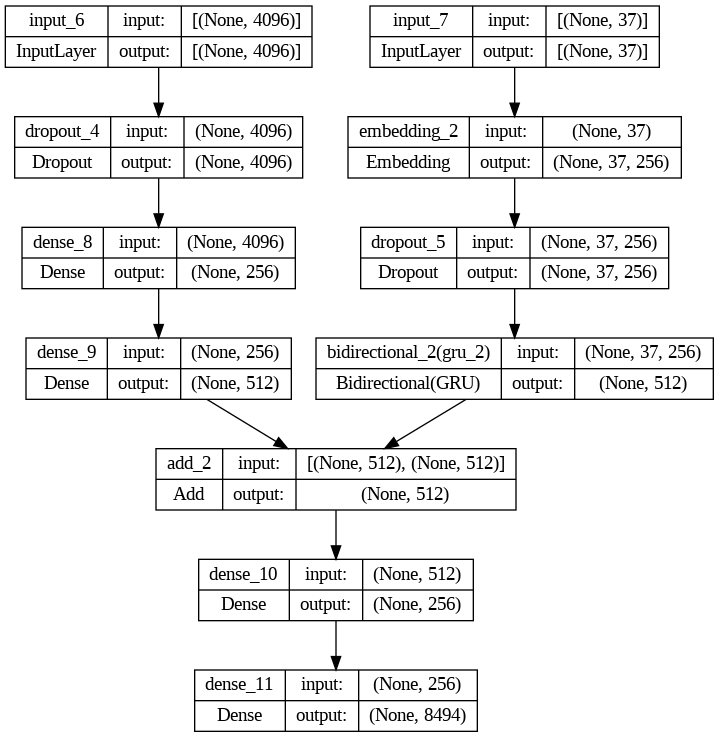

In [ ]:
# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe3 = Dense(512, activation='relu')(fe2)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = Bidirectional(GRU(256))(se2)

# Decoder model
decoder1 = add([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

modelGRU = Model(inputs=[inputs1, inputs2], outputs=outputs)
modelGRU.compile(loss='categorical_crossentropy', optimizer='adam')


# plot the model
plot_model(modelGRU, show_shapes=True)

In [ ]:
0000

# train the model
epochs = 25 #epoch in neural network is any int bwt 0-infi
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    modelGRU.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)



In [ ]:
# model.save(WORKING_DIR+'/best_modelGRU.h5')
model = modelGRU

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(modelGRU, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.157895
BLEU-2: 0.092384
BLEU-1: 0.197368
BLEU-2: 0.136638
BLEU-1: 0.201754
BLEU-2: 0.147686
BLEU-1: 0.184211
BLEU-2: 0.122213
BLEU-1: 0.178947
BLEU-2: 0.116370
BLEU-1: 0.179825
BLEU-2: 0.117347
BLEU-1: 0.176692
BLEU-2: 0.116808
BLEU-1: 0.174342
BLEU-2: 0.113833
BLEU-1: 0.175439
BLEU-2: 0.107659
BLEU-1: 0.173684
BLEU-2: 0.108330
BLEU-1: 0.181818
BLEU-2: 0.115766
BLEU-1: 0.182018
BLEU-2: 0.114536
BLEU-1: 0.190283
BLEU-2: 0.119338
BLEU-1: 0.189850
BLEU-2: 0.119556
BLEU-1: 0.187719
BLEU-2: 0.117761
BLEU-1: 0.190789
BLEU-2: 0.119081
BLEU-1: 0.201238
BLEU-2: 0.126478
BLEU-1: 0.201754
BLEU-2: 0.125509
BLEU-1: 0.195291
BLEU-2: 0.121339
BLEU-1: 0.196053
BLEU-2: 0.122888
BLEU-1: 0.196742
BLEU-2: 0.121186
BLEU-1: 0.196172
BLEU-2: 0.121247
BLEU-1: 0.196796
BLEU-2: 0.123542
BLEU-1: 0.197368
BLEU-2: 0.122938
BLEU-1: 0.196842
BLEU-2: 0.123781
BLEU-1: 0.196356
BLEU-2: 0.124549
BLEU-1: 0.198830
BLEU-2: 0.126184
BLEU-1: 0.194549
BLEU-2: 0.123332
BLEU-1: 0.194192
BLEU-2: 0.121076
BLEU-1: 0.1973

In [ ]:

import os
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(modelGRU, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)



---------------------Actual---------------------
A girl is stretched out in shallow water
A girl wearing a red and multi-colored bikini is laying on her back in shallow water .
A little girl in a red swimsuit is laying on her back in shallow water .
"A young girl is lying in the sand   while ocean water is surrounding her ."
Girl wearing a bikini lying on her back in a shallow pool of clear blue water .
--------------------Predicted--------------------
startseq in a red coat is walking through the snow with a red collar in the snow and snow and snow in its mouth is walking through the snow with a red ball in his mouth and a


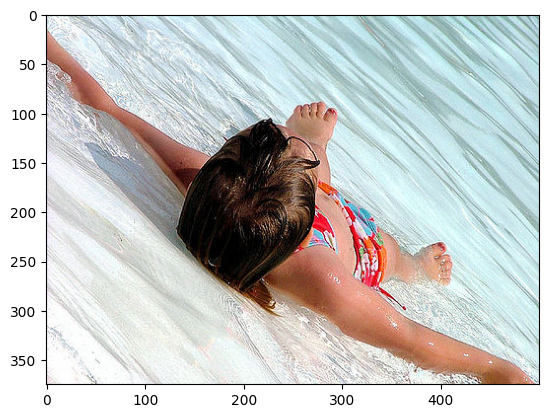

In [ ]:
generate_caption("667626_18933d713e.jpg")

# Hindi Caption Generation

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.6 MB/s eta 0:00:00


In [ ]:
import torch
import requests
from PIL import Image
from transformers import ViTFeatureExtractor, AutoTokenizer, \
                         VisionEncoderDecoderModel

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [ ]:
encoder_checkpoint = 'google/vit-base-patch16-224'
decoder_checkpoint = 'surajp/gpt2-hindi'
model_checkpoint = 'team-indain-image-caption/hindi-image-captioning'
feature_extractor = ViTFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
image = Image.open("/content/images2.jpg")

In [ ]:
import matplotlib.pyplot as plt

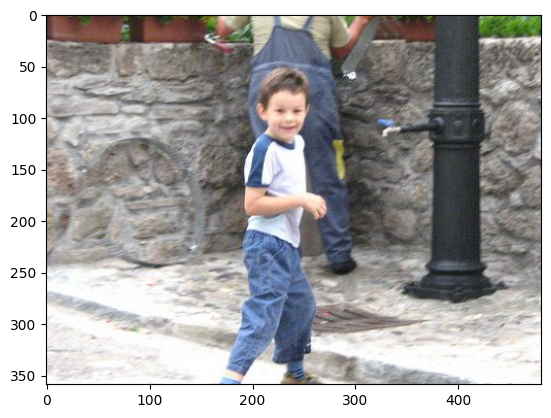

In [ ]:
plt.imshow(image)

In [ ]:
sample = feature_extractor(image, return_tensors="pt").pixel_values.to(device)
clean_text = lambda x: x.replace('<|endoftext|>','').split('\n')[0]

caption_ids = model.generate(sample, max_length = 50)[0]
caption_text = clean_text(tokenizer.decode(caption_ids))
print(caption_text)

एक युवा लड़का एक कार के पास सड़क पर चलता है।


In [ ]:
model.save("/content/modelGRU.h5")

In [ ]:
import tensorflow as tf
modelbi = tf.keras.models.load_model('/content/modelGRU.h5')

# Check its architecture
modelbi.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     